In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch
import seaborn as sns
from datetime import datetime

In [2]:
def analyzeMatch(
    filepath,
    result_col,
    metric_col,
    renamed_metric,
    threshold,
    low_label,
    high_label,
    title_prefix,
    filename
):
    df = pd.read_csv(filepath, header=[0, 1])
    df.columns = [''.join(col).strip().replace(' ', '') for col in df.columns.values]
    df.rename(columns={result_col: 'Result', metric_col: renamed_metric}, inplace=True)
    df = df[['Result', renamed_metric]]
    df[renamed_metric] = pd.to_numeric(df[renamed_metric], errors='coerce')
    df['Result'] = df['Result'].str.strip().str[0]
    df = df[df['Result'].isin(['W', 'D', 'L']) & df[renamed_metric].notna()]
    range_col = f"{renamed_metric}_Range"
    df[range_col] = df[renamed_metric].apply(lambda x: f'{low_label}' if x <= threshold else f'{high_label}')
    summary = df.groupby([range_col, 'Result']).size().unstack(fill_value=0)
    color_map = {'W': 'lightgreen', 'D': 'lightblue', 'L': 'red'}
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    for i, (range_label, row) in enumerate(summary.iterrows()):
        axs[i].pie(row, labels=row.index, autopct='%1.1f%%',
                   colors=[color_map.get(res, 'gray') for res in row.index],
                   textprops={'color': 'black', 'fontsize': 12})
        axs[i].set_title(f'{range_label} {title_prefix}')
    plt.suptitle(f'Wolves 25/26 Premier League Results vs. {title_prefix}', fontsize=14)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    winCount = summary.get('W', pd.Series(dtype=int))
    totCount = summary.sum(axis=1)
    winRate = (winCount / totCount * 100).round(1)
    for category in summary.index:
        wins = winCount.get(category, 0)
        total = totCount.get(category, 0)
        rate = winRate.get(category, 0.0)
        print(f"Wolves won {wins} out of {total} games ({rate}% win rate) with {category} {title_prefix.lower()}.")

In [32]:
# analyzeMatch(
#     filepath='wolves_passing_matchlogs.csv',
#     result_col='ForWolverhamptonWanderersResult',
#     metric_col='Unnamed:30_level_0PrgP',
#     renamed_metric='ProgressivePasses',
#     threshold=31,
#     low_label='31 or less',
#     high_label='32+',
#     title_prefix='Progressive Passes',
#     filename='wolves_progressive_passes.png'
# )

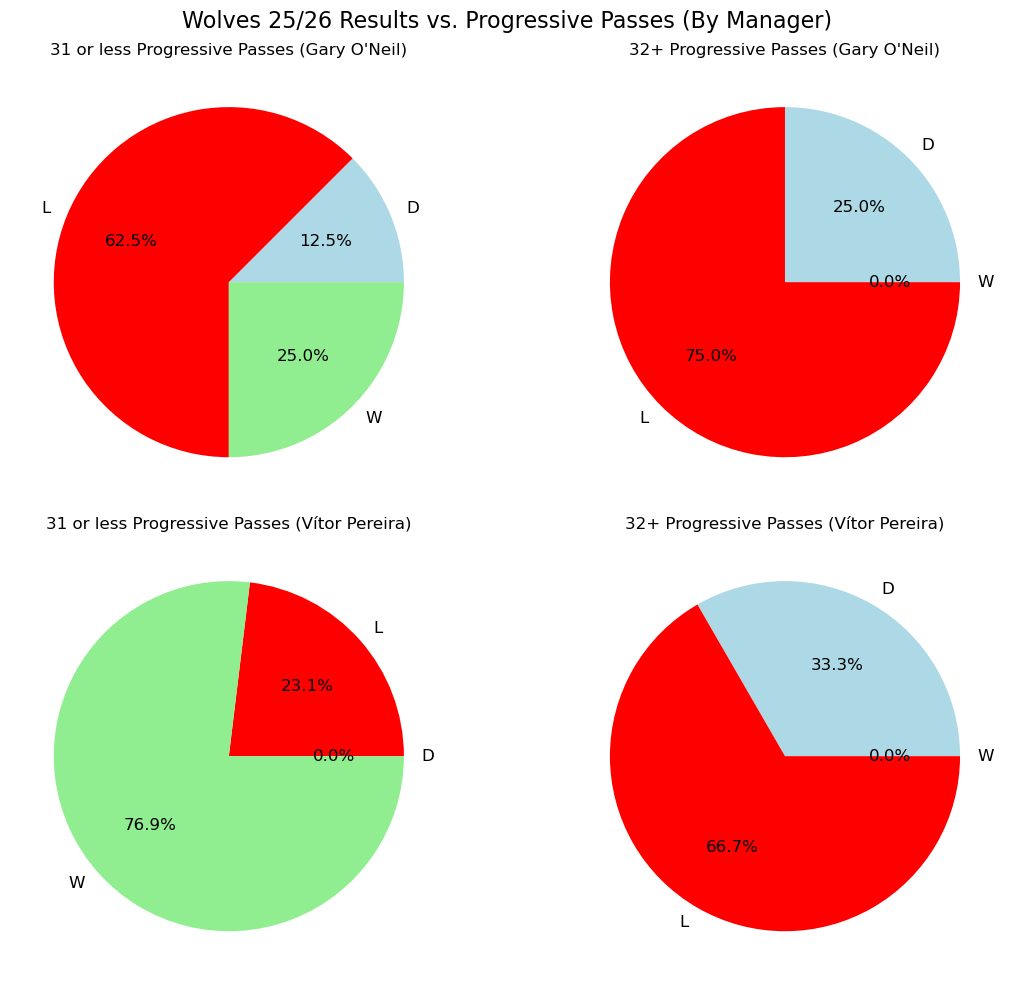

Gary O'Neil - 31 or less: 2 wins out of 8 (25.0% win rate)
Gary O'Neil - 32+: 0 wins out of 8 (0.0% win rate)
Vítor Pereira - 31 or less: 10 wins out of 13 (76.9% win rate)
Vítor Pereira - 32+: 0 wins out of 9 (0.0% win rate)


In [3]:
df_full = pd.read_csv('wolves_passing_matchlogs.csv', header=[0, 1])
df_full.columns = [''.join(col).strip().replace(' ', '') for col in df_full.columns.values]
df_full.rename(columns={
    'ForWolverhamptonWanderersResult': 'Result',
    'Unnamed:30_level_0PrgP': 'ProgressivePasses',
    'ForWolverhamptonWanderersDate': 'Date'
}, inplace=True)
df_full = df_full[['Result', 'ProgressivePasses', 'Date']]
df_full['ProgressivePasses'] = pd.to_numeric(df_full['ProgressivePasses'], errors='coerce')
df_full['Result'] = df_full['Result'].str.strip().str[0]
df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce')
df_full = df_full[df_full['Result'].isin(['W', 'D', 'L']) & df_full['ProgressivePasses'].notna() & df_full['Date'].notna()]
cutoff = pd.to_datetime('2024-12-22')
df_full['Manager'] = df_full['Date'].apply(lambda x: 'Gary O\'Neil' if x < cutoff else 'Vítor Pereira')
df_full['ProgressivePasses_Range'] = df_full['ProgressivePasses'].apply(lambda x: '31 or less' if x <= 31 else '32+')
summary_mgr = df_full.groupby(['Manager', 'ProgressivePasses_Range', 'Result']).size().unstack(fill_value=0)
color_map = {'W': 'lightgreen', 'D': 'lightblue', 'L': 'red'}
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
for i, manager in enumerate(['Gary O\'Neil', 'Vítor Pereira']):
    for j, pass_range in enumerate(['31 or less', '32+']):
        row = summary_mgr.loc[(manager, pass_range)]
        ax = axs[i][j]
        ax.pie(row, labels=row.index, autopct='%1.1f%%',
               colors=[color_map.get(res, 'gray') for res in row.index],
               textprops={'color': 'black', 'fontsize': 12})
        ax.set_title(f'{pass_range} Progressive Passes ({manager})')
plt.suptitle('Wolves 25/26 Results vs. Progressive Passes (By Manager)', fontsize=16)
plt.tight_layout()
plt.savefig('wolves_progressive_passes_manager_split.png', dpi=300, bbox_inches='tight')
plt.show()
for (manager, pass_range), row in summary_mgr.groupby(level=[0, 1]):
    wins = row.loc[(manager, pass_range)].get('W', 0)
    total = row.loc[(manager, pass_range)].sum()
    win_rate = (wins / total * 100).round(1) if total > 0 else 0.0
    print(f"{manager} - {pass_range}: {wins} wins out of {total} ({win_rate}% win rate)")

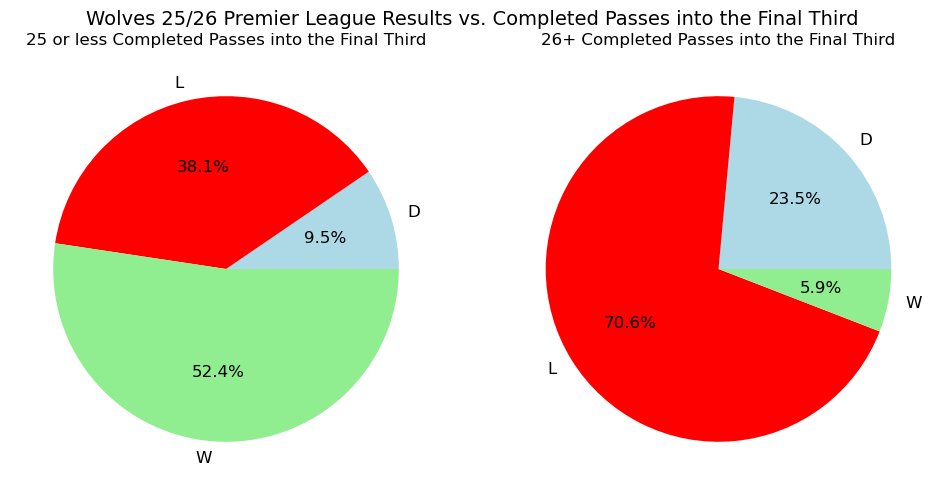

Wolves won 11 out of 21 games (52.4% win rate) with 25 or less completed passes into the final third.
Wolves won 1 out of 17 games (5.9% win rate) with 26+ completed passes into the final third.


In [4]:
analyzeMatch(
    filepath='wolves_passing_matchlogs.csv',
    result_col='ForWolverhamptonWanderersResult',
    metric_col='Unnamed:27_level_01/3',
    renamed_metric='CompletedFinalThirdPasses',
    threshold=25,
    low_label='25 or less',
    high_label='26+',
    title_prefix='Completed Passes into the Final Third',
    filename='wolves_final_third_passes.png'
)

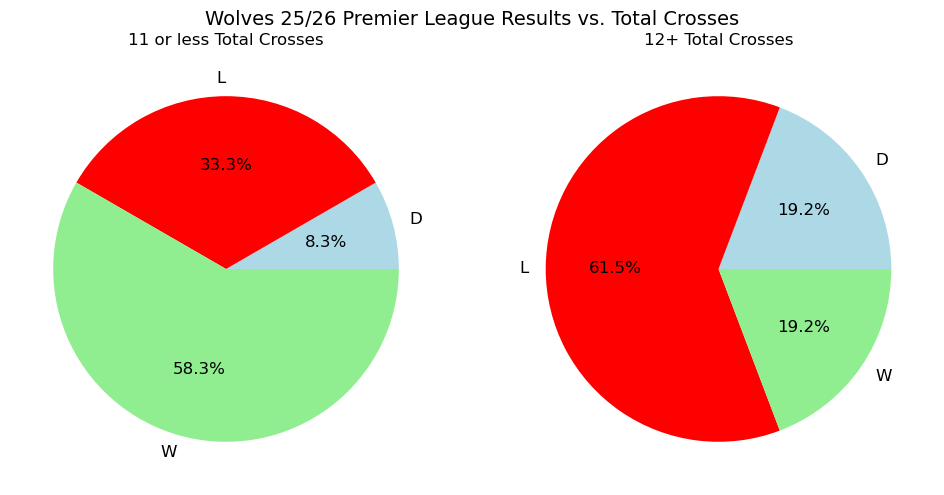

Wolves won 7 out of 12 games (58.3% win rate) with 11 or less total crosses.
Wolves won 5 out of 26 games (19.2% win rate) with 12+ total crosses.


In [5]:
analyzeMatch(
    filepath='wolves_misc_matchlogs.csv',
    result_col='ForWolverhamptonWanderersResult',
    metric_col='PerformanceCrs',
    renamed_metric='Crosses',
    threshold=11,
    low_label='11 or less',
    high_label='12+',
    title_prefix='Total Crosses',
    filename='wolves_crosses.png'
)

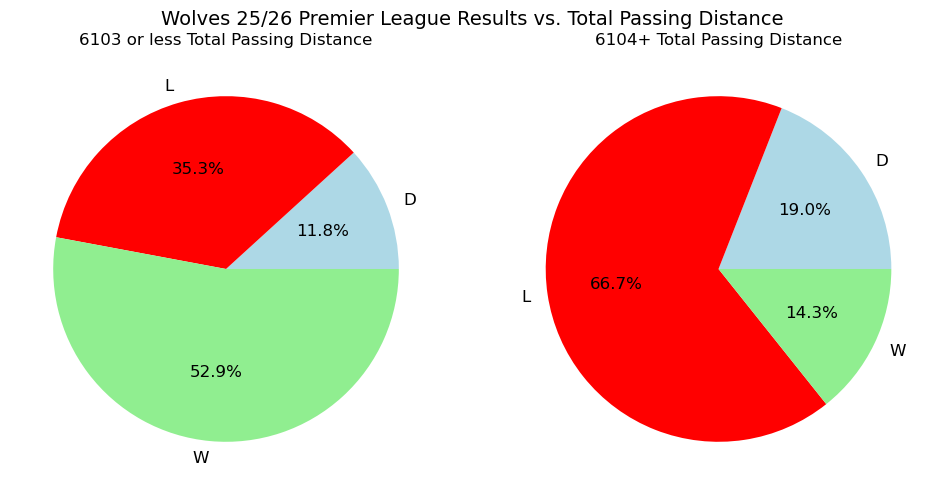

Wolves won 9 out of 17 games (52.9% win rate) with 6103 or less total passing distance.
Wolves won 3 out of 21 games (14.3% win rate) with 6104+ total passing distance.


In [7]:
analyzeMatch(
    filepath='wolves_passing_matchlogs.csv',
    result_col='ForWolverhamptonWanderersResult',
    metric_col='TotalTotDist',
    renamed_metric='TotalPassingDistance',
    threshold=6103,
    low_label='6103 or less',
    high_label='6104+',
    title_prefix='Total Passing Distance',
    filename='wolves_passing_distance.png'
)